# Import libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Import and clean tables

## Wikipedia episode data

In [2]:
html_1 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1-20)')
bs_1 = BeautifulSoup(html_1.read(),'html.parser')

html_2 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes')
bs_2 = BeautifulSoup(html_2.read(),'html.parser')

In [37]:
episode_tables = bs_1.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes = [pd.read_html(str(i))[0] for i in episode_tables if 'The Simpsons Movie' not in str(i)]

episode_tables = bs_2.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes.extend([pd.read_html(str(i))[0] for i in episode_tables if ('Screenplay by' not in str(i)) and ('Ratings/' not in str(i))])

for i in range(len(episodes)):
    episodes[i]['seasonNumber'] = i+1

episodes_df = pd.concat(episodes).reset_index(drop=True)

In [38]:
# fix problems with episodes 608,608

# old_ep = pd.DataFrame(episodes_df.iloc[607].copy()).transpose()
# old_ep[['No.overall','No. inseason','Prod.code']] = [608,12,'WABF04']

# new_ep = pd.DataFrame(episodes_df.iloc[607].copy()).transpose()
# new_ep[['No.overall','No. inseason','Prod.code']] = [609,13,'WABF05']

# episodes_df = pd.concat([episodes_df.iloc[:607],old_ep,new_ep,episodes_df.iloc[608:]]).reset_index(drop=True)

episodes_df.loc[607,['No.overall','No. inseason','Prod.code']]=[608,12,'WABF04']
episodes_df.loc[608:,'No.overall'] -= 1 
episodes_df.loc[608:616,'No. inseason'] -= 1 


# fix problems with 681, 682
old_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
old_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [680,19,'April 26, 2020','ZABF12','1.35']

new_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
new_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [681,20,'May 3, 2020','ZABF13','1.36']

episodes_df = pd.concat([episodes_df.iloc[:679],old_ep,new_ep,episodes_df.iloc[680:]]).reset_index(drop=True)

# convert ratings to numerical values
episodes_df['U.S. viewers(millions)'] = pd.to_numeric(episodes_df['U.S. viewers(millions)'].replace('\[.*\]','',regex=True))

# convert dates to datetime
episodes_df['Original air date'] = pd.to_datetime(episodes_df['Original air date'].replace('\[.*\]','',regex=True),infer_datetime_format=True)

#change column names
episodes_df.columns = ['overallNumber', 'episodeNumber', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'US_viewers_millions',
       'seasonNumber']

## IMDB ratings

In [39]:
imdb_episodes_df = pd.read_csv('./data/episode_data.txt',sep='\t')
imdb_episodes_df = imdb_episodes_df[imdb_episodes_df['parentTconst']=='tt0096697']
imdb_episodes_df['seasonNumber'] = pd.to_numeric(imdb_episodes_df['seasonNumber'])
imdb_episodes_df['episodeNumber'] = pd.to_numeric(imdb_episodes_df['episodeNumber'])
imdb_episodes_df = imdb_episodes_df.sort_values(['seasonNumber','episodeNumber']).reset_index(drop=True)

In [40]:
imdb_ratings_df = pd.read_csv('./data/rating_data.txt',sep='\t')
imdb_df = imdb_episodes_df.merge(imdb_ratings_df,on='tconst',how='inner')

## Combine dfs

In [161]:
simpsons_df = episodes_df.merge(imdb_df,on=['seasonNumber','episodeNumber'],how='inner').drop(['Directed by', 'Written by','parentTconst',],axis=1)
simpsons_df

,overallNumber,episodeNumber,Title,Original air date,Prod.code,US_viewers_millions,seasonNumber,tconst,averageRating,numVotes
0,1,1,"""Simpsons Roasting on an Open Fire""",1989-12-17,7G08,26.70,1,tt0348034,8.2,6326
1,2,2,"""Bart the Genius""",1990-01-14,7G02,24.50,1,tt0756593,7.7,4154
2,3,3,"""Homer's Odyssey""",1990-01-21,7G03,27.50,1,tt0701124,7.4,3664
3,4,4,"""There's No Disgrace Like Home""",1990-01-28,7G04,20.20,1,tt0756399,7.7,3594
4,5,5,"""Bart the General""",1990-02-04,7G05,27.10,1,tt0701059,8.0,3639
...,...,...,...,...,...,...,...,...,...,...
700,701,18,"""Burger Kings""",2021-04-11,QABF11,1.24,32,tt13977692,6.8,277
701,702,19,"""Panic on the Streets of Springfield""",2021-04-18,QABF12,1.31,32,tt13977716,6.2,380
702,703,20,"""Mother and Child Reunion""",2021-05-09,QABF14,1.11,32,tt14056918,7.1,248
703,704,21,"""The Man from G.R.A.M.P.A.""",2021-05-16,QABF13,1.06,32,tt14056916,6.4,213


## Director and writer dfs

In [163]:
# Episode number and their respective writers, regex to separate joined names
episode_writer = pd.concat([episodes_df['overallNumber'],episodes_df['Written by'].replace('\[.*\]','',regex=True)],axis=1,keys=['overallNumber','Written by'])

re_pattern = r' & |, | and |Story by: |Teleplay by: | \(wraparounds\)'
re_pattern_joinednames = r'([a-z]{2})([A-Z]{1})'
for i in range(len(episode_writer)):
    
    cond = re.search(re_pattern+'|'+re_pattern_joinednames, episode_writer.loc[i,'Written by'])

    if cond:
        s = episode_writer.loc[i,'Written by'].replace(u'\u200a', '')
        
        clean = re.compile(r'([a-z]{2})([A-Z]{1})')
        s = re.sub(clean,r'\1 & \2',s)
        
        names = re.split(re_pattern, s)
        names = list(filter(None,names))
        
        for n in names:
            episode_writer = episode_writer.append({'overallNumber':episode_writer.loc[i,'overallNumber'],'Written by':n},ignore_index=True)
        episode_writer.loc[i,:] = [pd.NA,pd.NA]

episode_writer=episode_writer.sort_values('overallNumber').dropna().reset_index(drop=True)
episode_writer.iloc[:10]

,overallNumber,Written by
0,1,Mimi Pond
1,2,Jon Vitti
2,3,Wallace Wolodarsky
3,3,Jay Kogen
4,4,Mike Reiss
5,4,Al Jean
6,5,John Swartzwelder
7,6,Mike Reiss
8,6,Al Jean
9,7,John Swartzwelder


In [159]:
# Episode number and their respective directors, regex to separate joined names
episode_director = pd.concat([episodes_df['overallNumber'],episodes_df['Directed by'].replace('\[.*\]','',regex=True)],axis=1,keys=['overallNumber','Directed by'])

re_pattern = r' & |, | and |Story by: |Teleplay by: | \(wraparounds\)'
re_pattern_joinednames = r'([a-z]{2})([A-Z]{1})'
for i in range(len(episode_director)):
    
    cond = re.search(re_pattern+'|'+re_pattern_joinednames, episode_director.loc[i,'Directed by'])

    if cond:
        s = episode_director.loc[i,'Directed by'].replace(u'\u200a', '')
        
        clean = re.compile(r'([a-z]{2})([A-Z]{1})')
        s = re.sub(clean,r'\1 & \2',s)
        
        names = re.split(re_pattern, s)
        names = list(filter(None,names))
        
        for n in names:
            episode_director = episode_director.append({'overallNumber':episode_director.loc[i,'overallNumber'],'Directed by':n},ignore_index=True)
        episode_director.loc[i,:] = [pd.NA,pd.NA]

episode_director=episode_director.sort_values('overallNumber').dropna().reset_index(drop=True)
episode_director.iloc[670:750]

,overallNumber,Directed by
670,649,Rob Oliver
671,650,Chris Clements
672,651,Matthew Nastuk
673,652,Timothy Bailey
674,653,Mark Kirkland
675,654,Steven Dean Moore
676,655,Rob Oliver
677,656,Chris Clements
678,657,Jennifer Moeller
679,658,Michael Polcino


## Guest stars

# EDA

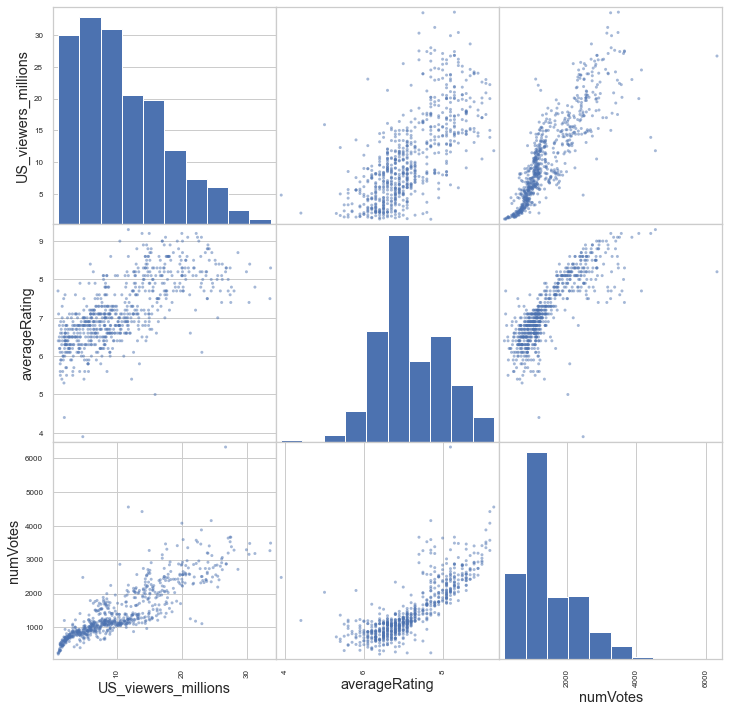

In [185]:
pd.plotting.scatter_matrix(simpsons_df,figsize=(12,12),diagonal='hist')
plt.show()

## Color square diagrams

In [92]:
def plot_color_square(column,label=None):
    if label is None:
        label = column
    episodes_num = simpsons_df.groupby('seasonNumber').count()['episodeNumber'].to_numpy()
    episodes_max = np.max(episodes_num)
    seasons = 32

    square = np.empty([episodes_max,seasons])
    square[:]=np.nan
    
    for s in range(seasons):
        for e in range(episodes_num[s]):
            square[e,s] = simpsons_df[(simpsons_df['seasonNumber']==s+1) & (simpsons_df['episodeNumber']==e+1)][column]


    plt.figure(figsize=(15,15))
    plt.grid(b=True,which='both',alpha=0.3)
    plt.minorticks_on()
    cmap = mpl.cm.get_cmap("RdYlGn").copy()
    cmap.set_bad("white")
    plt.pcolormesh(square,cmap=cmap,edgecolors='k',vmin=np.quantile(simpsons_df[column].dropna(),0.01),vmax=np.quantile(simpsons_df[column].dropna(),0.99))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0.5,32.5))
    ax.set_xticklabels(range(1,33))
    ax.set_yticks(np.arange(0.5,25.5))
    ax.set_yticklabels(range(1,26))
    plt.colorbar(shrink=0.5).set_label(label)
    plt.ylabel('Episode number')
    plt.xlabel('Season')
    plt.title(label+' for every Simpsons episode')
    plt.show()

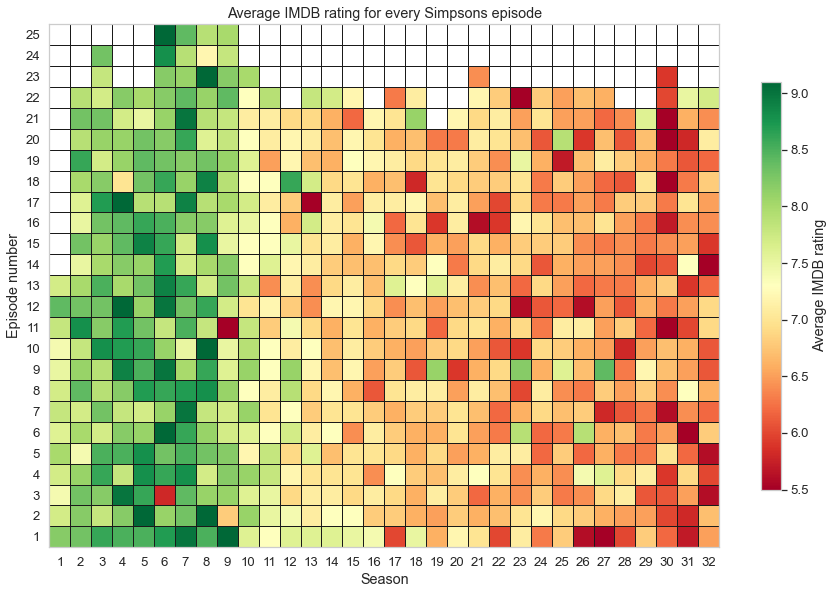

In [93]:
plot_color_square('averageRating','Average IMDB rating')

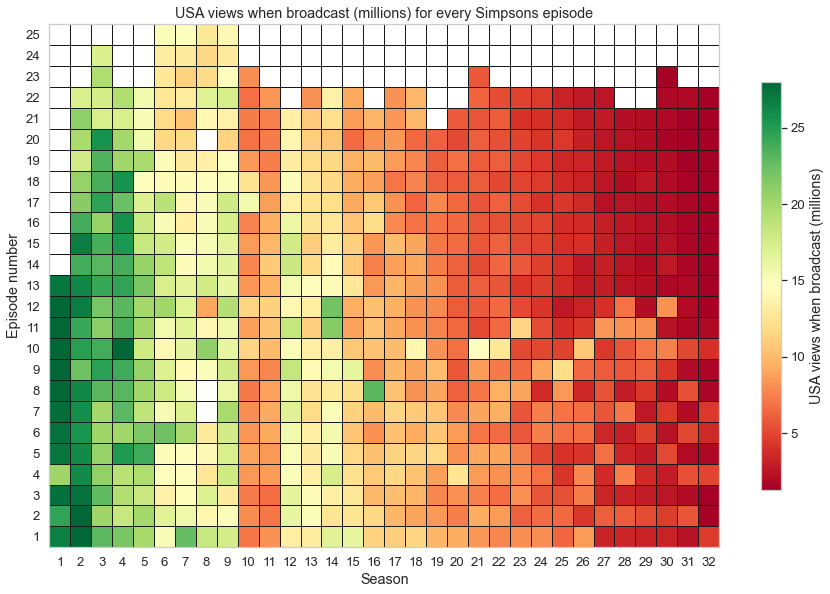

In [94]:
plot_color_square('US_viewers_millions', 'USA views when broadcast (millions)')

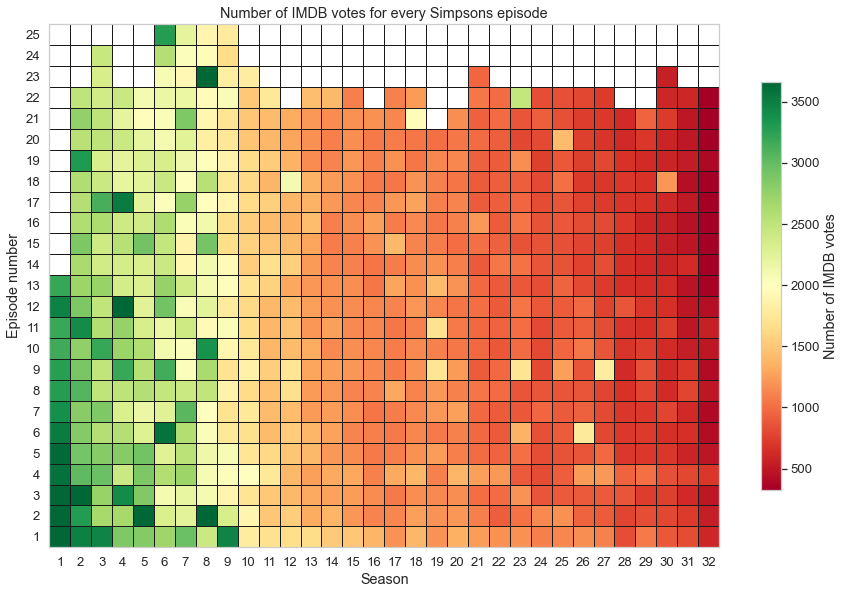

In [95]:
plot_color_square('numVotes', 'Number of IMDB votes')

## Average plots with quantile ranges

In [86]:
def plot_line_quantiles(column,label=None):
    if label is None:
        label = column
    plt.figure(figsize=(12,8))
    sns.set_theme(style='whitegrid',font_scale=1.2)

    avgs = simpsons_df.groupby('seasonNumber').mean()
    stds = simpsons_df.groupby('seasonNumber').std()
    quant = lambda x: simpsons_df.groupby('seasonNumber').quantile(x)

    plt.plot(np.arange(0,32),avgs[column],linewidth=4)
    for i in np.arange(1.5,5.5):
        plt.fill_between(np.arange(0,32),quant(1-i/10)[column],quant(i/10)[column],alpha=0.07,color='blue')

    # plt.plot(np.arange(0,32),avgs['US_viewers_millions'],linewidth=4)
    # plt.fill_between(np.arange(0,32),avgs['US_viewers_millions']-stds['US_viewers_millions'],avgs['US_viewers_millions']+stds['US_viewers_millions'],alpha=0.2)

    plt.grid(b=True,alpha=0.3)
    ax = plt.gca()
    ax.set_xticks(np.arange(0,32))
    ax.set_xticklabels(range(1,33))
    plt.xlim([0,31])
    plt.xlabel('Season')
    plt.ylabel(label)
    plt.title(label+' for every season of The Simpsons')
    
    plt.show()

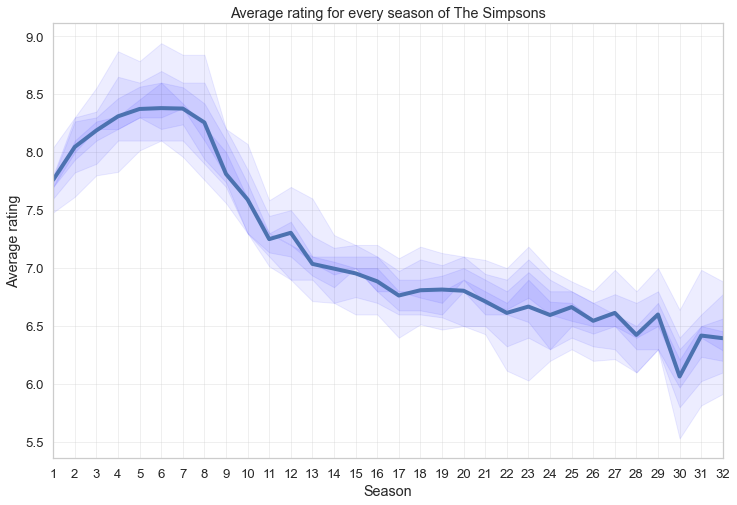

In [87]:
plot_line_quantiles('averageRating', 'Average rating')

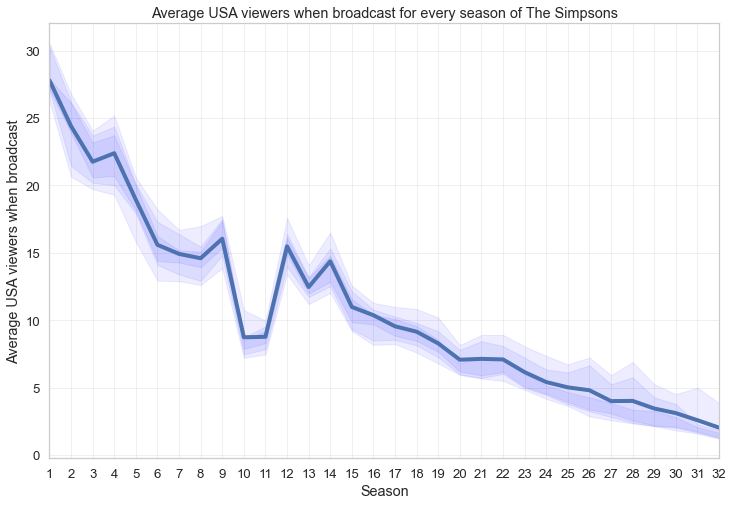

In [83]:
plot_line_quantiles('US_viewers_millions', 'Average USA viewers when broadcast')

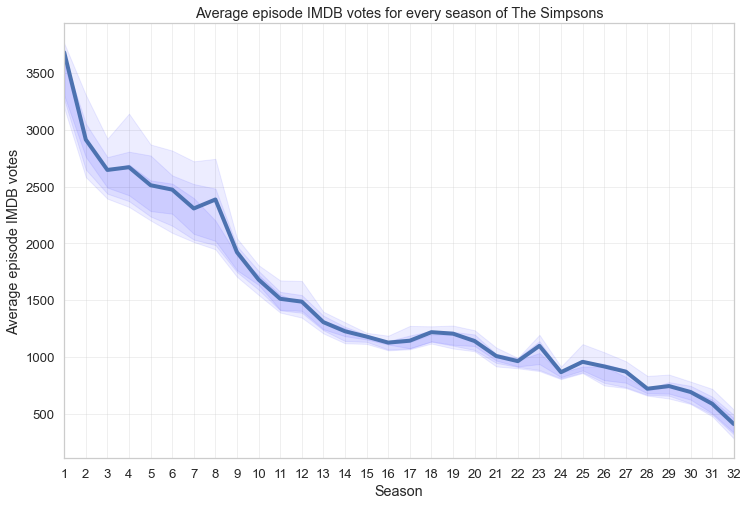

In [85]:
plot_line_quantiles('numVotes', 'Average episode IMDB votes')

## Staff comparisons

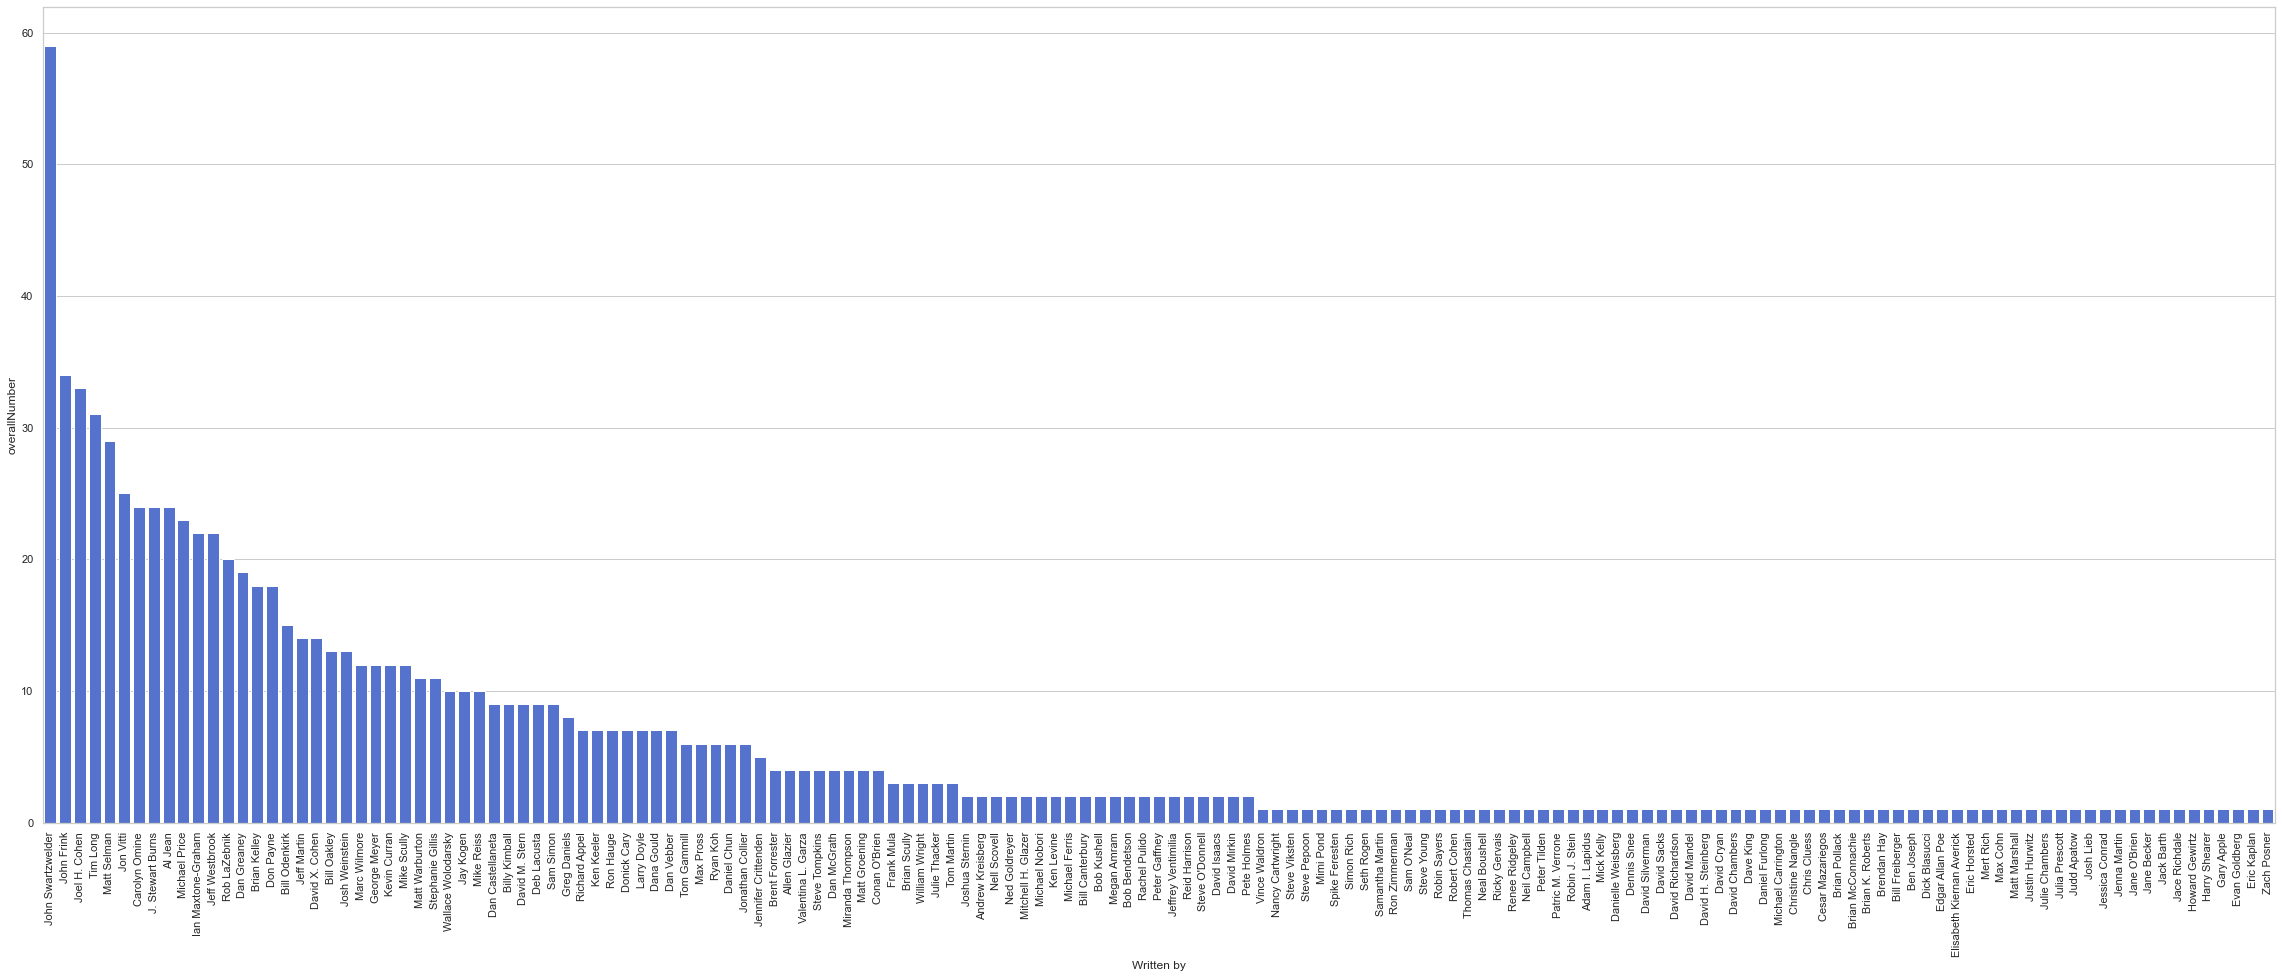

In [118]:
data = episode_writer.groupby('Written by').count().sort_values('overallNumber',ascending=False)

plt.figure(figsize=(40,15))
sns.set_theme(style='whitegrid')
ax=sns.barplot(x=data.index,y='overallNumber', data=data, color='royalblue')
plt.xticks(rotation=90)
plt.show()

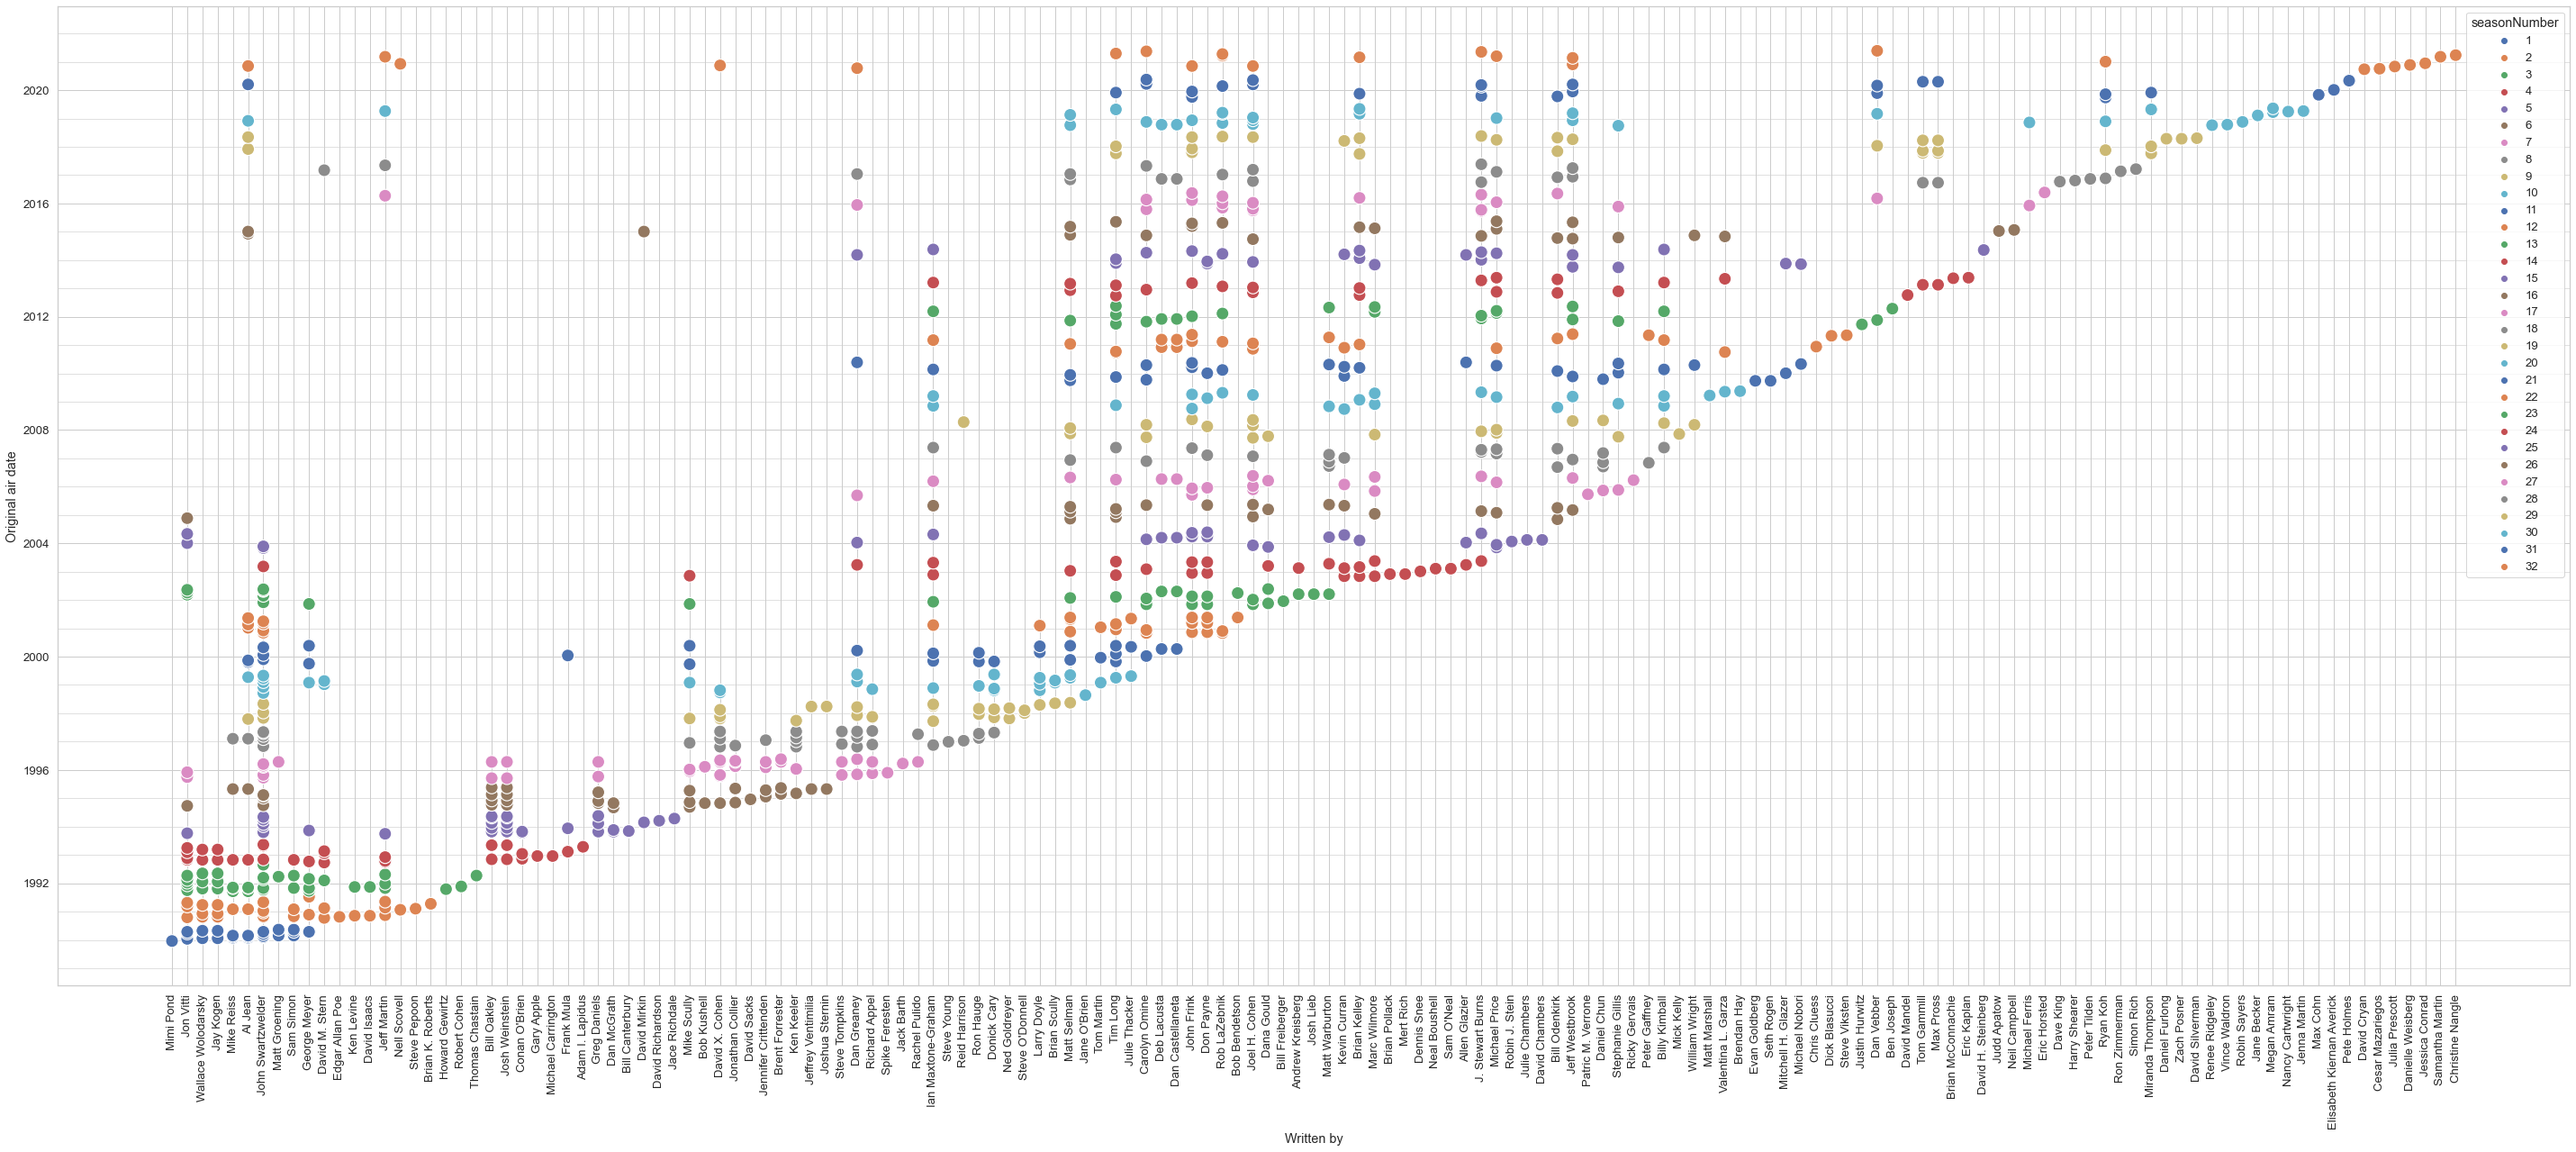

In [148]:
merged_df = simpsons_df.merge(episode_writer,on='overallNumber',how='inner')

plt.figure(figsize=(50,20))
sns.set_theme(style='whitegrid',font_scale=1.2)
ax = sns.scatterplot(x='Written by',
                     y='Original air date',
                     hue=merged_df['seasonNumber'].apply(str),
                     data=merged_df,
                     palette='deep',
                     s=200)
plt.grid(b=True,which='minor',axis='y',alpha=0.6)
plt.minorticks_on()
plt.xticks(rotation=90)
plt.show()

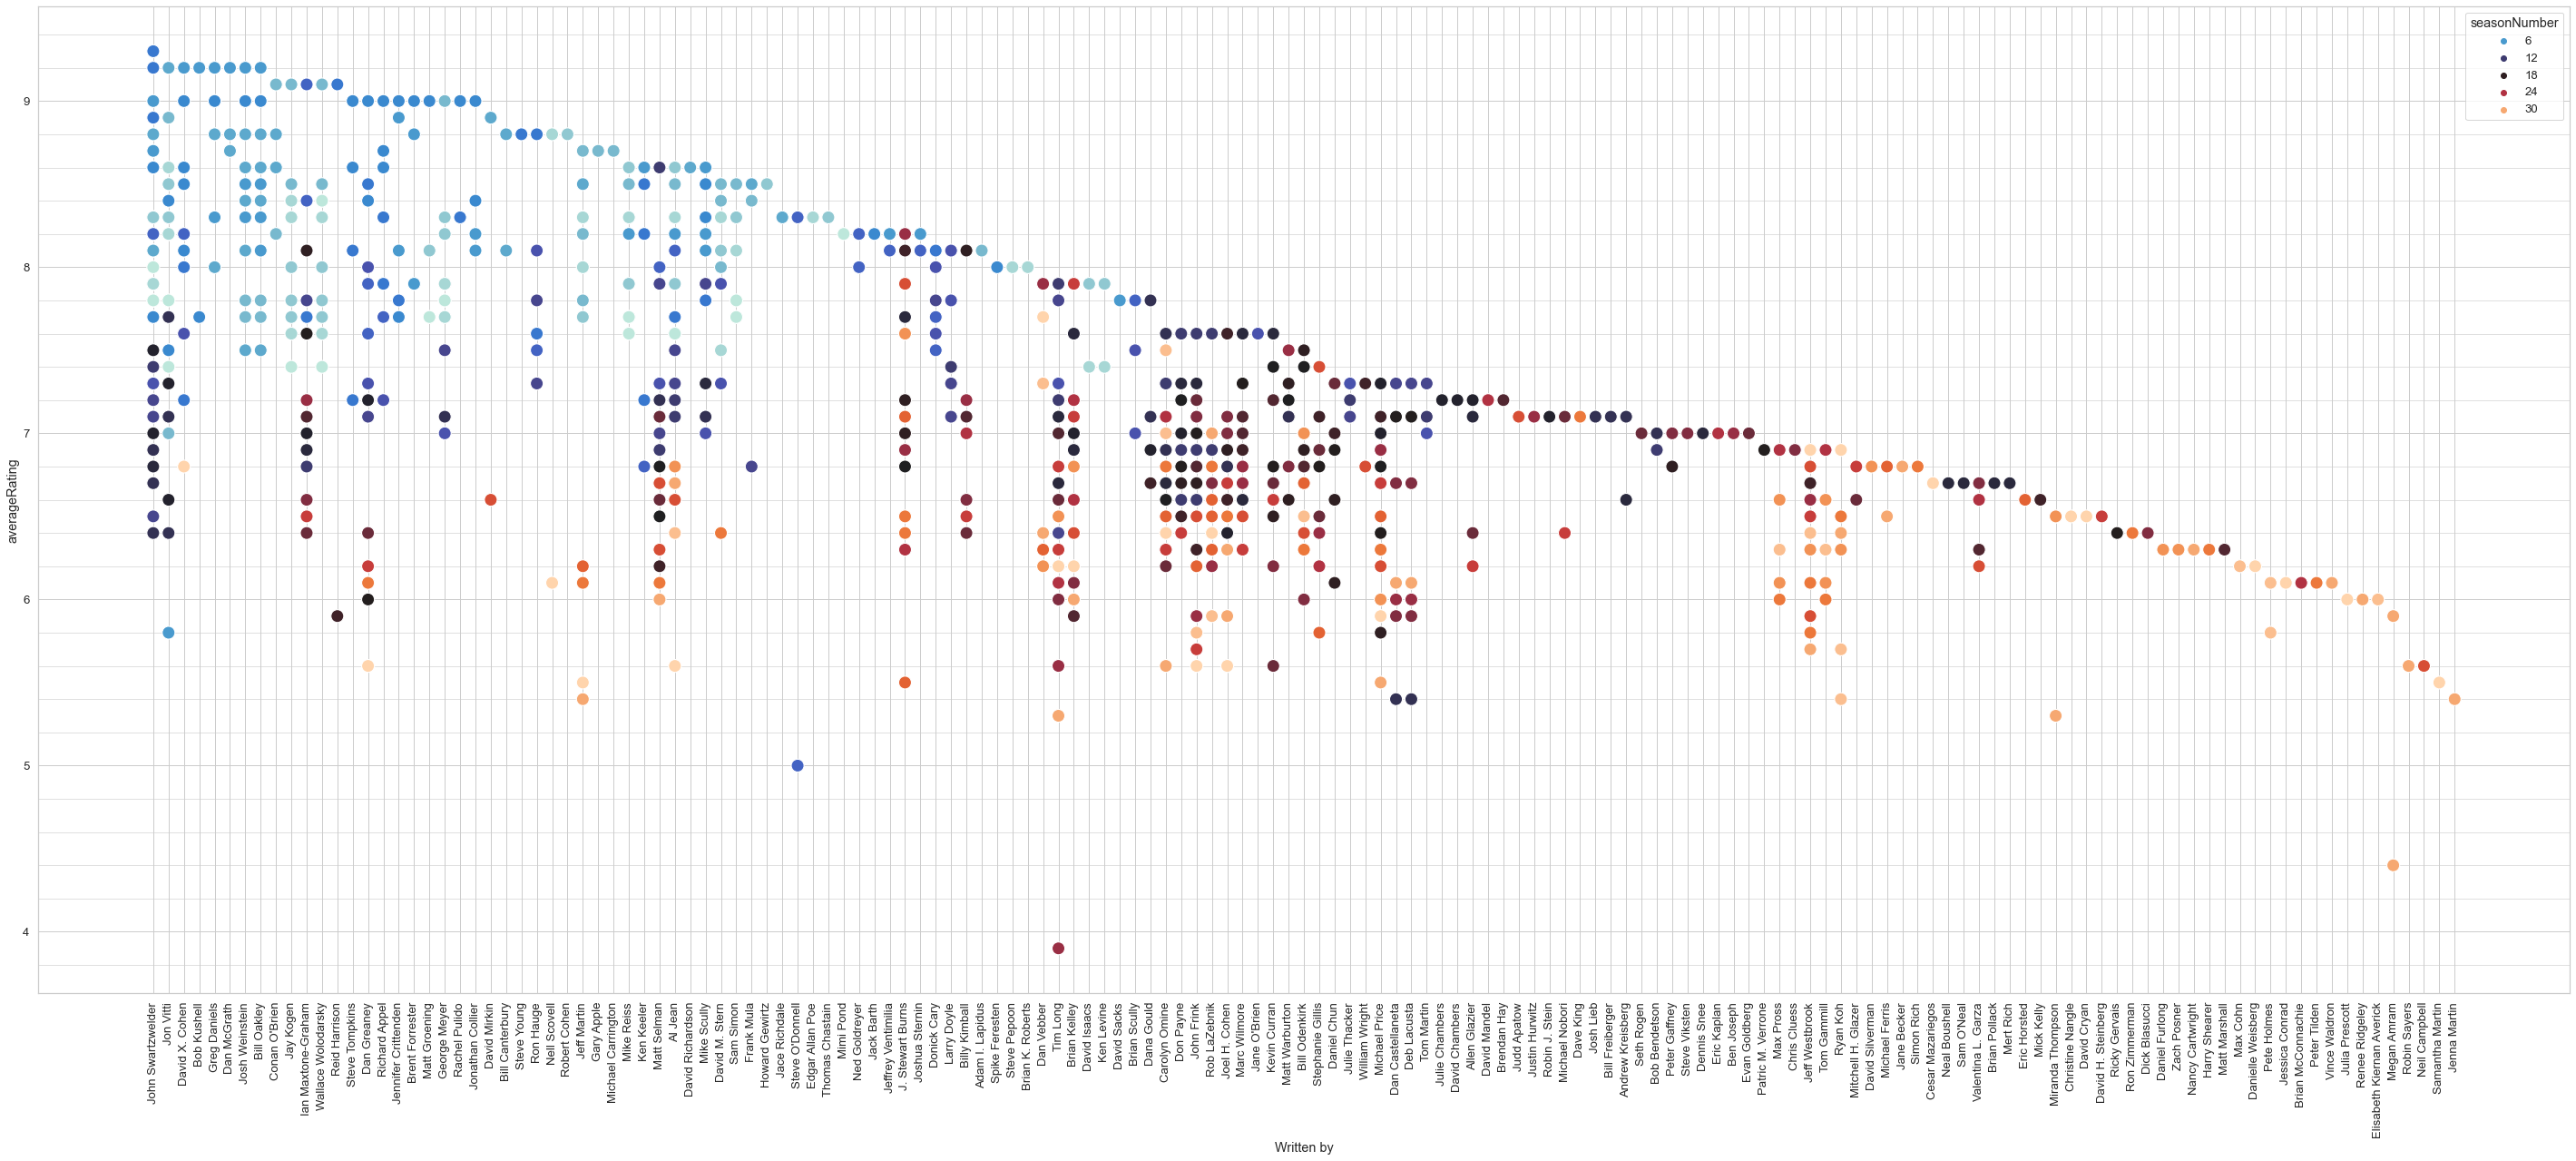

In [149]:
merged_df = simpsons_df.merge(episode_writer,on='overallNumber',how='inner').sort_values('averageRating',ascending=False)

plt.figure(figsize=(50,20))
sns.set_theme(style='whitegrid',font_scale=1.2)
ax = sns.scatterplot(x='Written by',
                     y='averageRating',
                     hue=merged_df['seasonNumber'],
                     data=merged_df,
                     palette='icefire',
                     s=200)
plt.grid(b=True,which='minor',axis='y',alpha=0.6)
plt.minorticks_on()
plt.xticks(rotation=90)
plt.show()

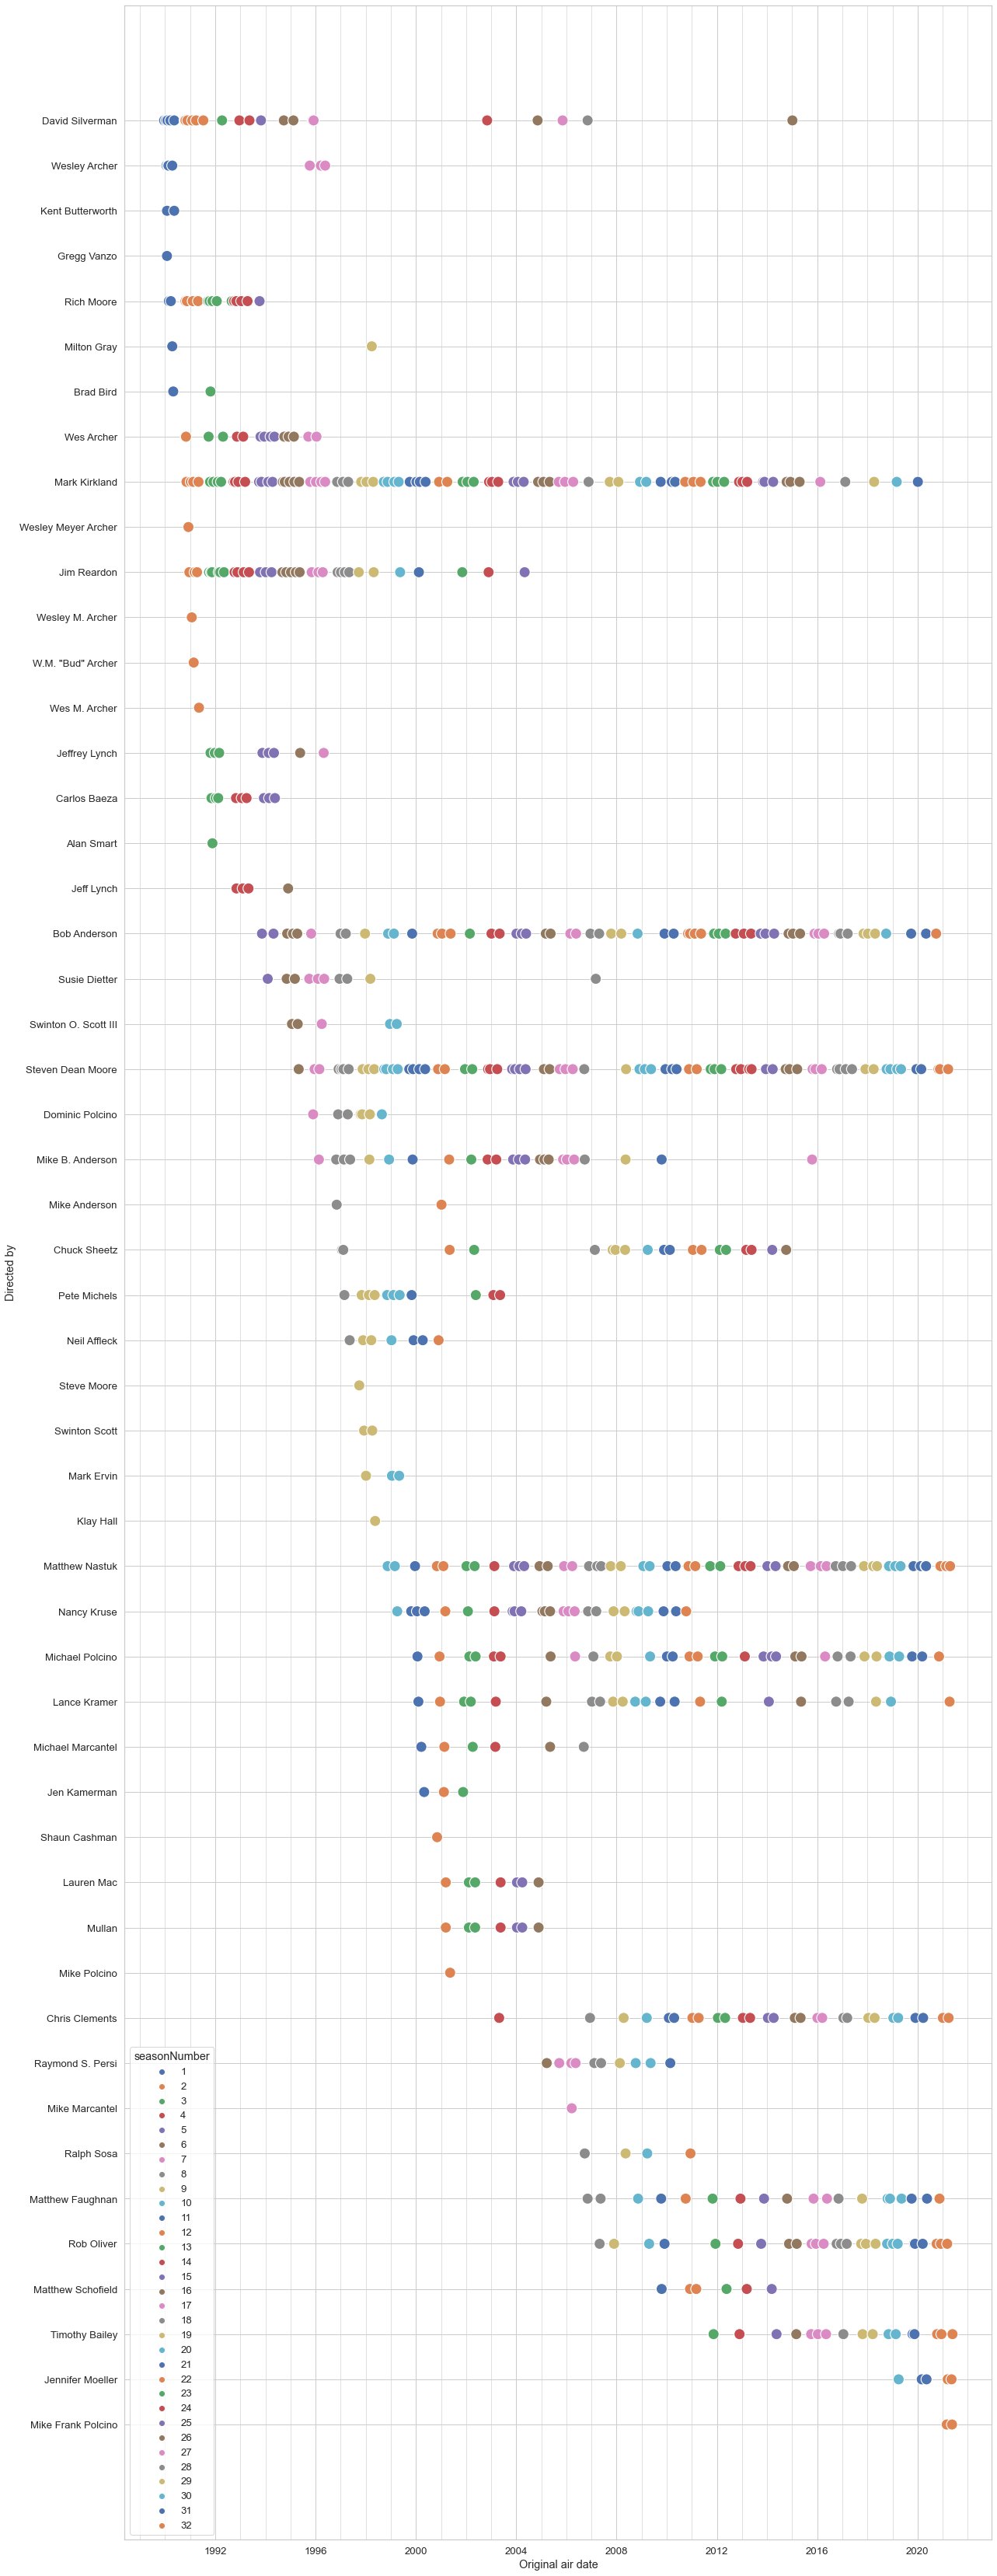

In [235]:
merged_df = simpsons_df.merge(episode_director,on='overallNumber',how='inner')

plt.figure(figsize=(20,60))
sns.set_theme(style='whitegrid',font_scale=1.2)
ax = sns.scatterplot(x='Original air date',
                     y='Directed by',
                     hue=merged_df['seasonNumber'].apply(str),
                     data=merged_df,
                     palette='deep',
                     s=200)
plt.grid(b=True,which='minor',axis='x',alpha=0.6)
plt.minorticks_on()
plt.show()